# Manipulating Dates/Times

In this lecture, we will use `pyspark` functions to

1. Extract date- and time-parts
2. Difference and offset dates.

In [1]:
from pyspark.sql import SparkSession
from more_pyspark import to_pandas

spark = SparkSession.builder.appName('Ops').getOrCreate()

22/11/05 17:50:29 WARN Utils: Your hostname, jt7372wd222 resolves to a loopback address: 127.0.1.1; using 172.30.75.123 instead (on interface eth0)
22/11/05 17:50:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/05 17:50:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/05 17:50:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/05 17:50:32 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Example Data

#### Example 1 - Uber data

In [2]:
from uber_schema import uber_schema, uber_datetime_format

uber_april = spark.read.csv('./data/uber-raw-data-apr14-sample.csv', 
                            header=True, 
                            schema=uber_schema,
                            timestampFormat=uber_datetime_format
                           )

uber_april.take(5) >> to_pandas

,Date/Time,Lat,Lon,Base
0,2014-04-18 21:38:00,40.7359,-73.9852,B02682
1,2014-04-23 15:19:00,40.7642,-73.9543,B02598
2,2014-04-10 07:15:00,40.7138,-74.0103,B02598
3,2014-04-11 15:23:00,40.7847,-73.9698,B02682
4,2014-04-07 17:26:00,40.6460,-73.7767,B02598


#### Example 2 - MoMA exhibitions

In [3]:
from MoMA_schema import exhib_schema, exhib_date_format

exhibitions = spark.read.csv('./data/MoMAExhibitions1929to1989.csv', 
                             header=True, 
                             schema=exhib_schema,
                             encoding="ISO-8859-1",
                             dateFormat=exhib_date_format)
exhibitions.take(2) >> to_pandas # No more "bad" symbols

22/11/05 17:50:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,ExhibitionID,ExhibitionNumber,ExhibitionTitle,ExhibitionCitationDate,ExhibitionBeginDate,ExhibitionEndDate,ExhibitionSortOrder,ExhibitionURL,ExhibitionRole,ExhibitionRoleinPressRelease,...,Institution,Nationality,ConstituentBeginDate,ConstituentEndDate,ArtistBio,Gender,VIAFID,WikidataID,ULANID,ConstituentURL
0,2557,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",1929-11-07,1929-12-07,1,moma.org/calendar/exhibitions/1767,Curator,Director,...,None,American,1902,1981,"American, 19021981",Male,109252853,Q711362,500241556,moma.org/artists/9168
1,2557,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",1929-11-07,1929-12-07,1,moma.org/calendar/exhibitions/1767,Artist,Artist,...,None,French,1839,1906,"French, 18391906",Male,39374836,Q35548,500004793,moma.org/artists/1053


## Extracting date- and time-parts

* Primary/typical transformation
* `pyspark` provides datepart and timepart functions

In [4]:
from pyspark.sql.functions import col
from pyspark.sql.functions import to_date, month, year, dayofmonth, dayofweek # dateparts
from pyspark.sql.functions import hour, minute, second # time parts

#### Extracting (many) date- and time-parts using `withColumn` [Messy]

In [5]:
(uber_april
 .withColumn('date', to_date(col('Date/Time')))
 .withColumn('day of month', dayofmonth(col('Date/Time')))
 .withColumn('hour', month(col('Date/Time')))
 .withColumn('year', year(col('Date/Time')))
 .withColumn('day of week', dayofweek(col('Date/Time')))
 .withColumn('hour', hour(col('Date/Time')))
 .withColumn('minute', minute(col('Date/Time')))
 .take(5)
) >> to_pandas

,Date/Time,Lat,Lon,Base,date,day of month,hour,year,day of week,minute
0,2014-04-18 21:38:00,40.7359,-73.9852,B02682,2014-04-18,18,21,2014,6,38
1,2014-04-23 15:19:00,40.7642,-73.9543,B02598,2014-04-23,23,15,2014,4,19
2,2014-04-10 07:15:00,40.7138,-74.0103,B02598,2014-04-10,10,7,2014,5,15
3,2014-04-11 15:23:00,40.7847,-73.9698,B02682,2014-04-11,11,15,2014,6,23
4,2014-04-07 17:26:00,40.6460,-73.7767,B02598,2014-04-07,7,17,2014,2,26


#### Extracting (many) date- and time-parts using `select` and `alias [Less Messy]

In [6]:
(uber_april
 .select('Date/Time',
         to_date(col('Date/Time')).alias('date'),
         dayofmonth(col('Date/Time')).alias('day of month'),
         month(col('Date/Time')).alias('hour'),
         year(col('Date/Time')).alias('year'),
         dayofweek(col('Date/Time')).alias('day of week'),
         hour(col('Date/Time')).alias('hour'),
         minute(col('Date/Time')).alias('minute'))
 .take(5)
) >> to_pandas

,Date/Time,date,day of month,hour,year,day of week,minute
0,2014-04-18 21:38:00,2014-04-18,18,21,2014,6,38
1,2014-04-23 15:19:00,2014-04-23,23,15,2014,4,19
2,2014-04-10 07:15:00,2014-04-10,10,7,2014,5,15
3,2014-04-11 15:23:00,2014-04-11,11,15,2014,6,23
4,2014-04-07 17:26:00,2014-04-07,7,17,2014,2,26


## <font color="red"> Exercise 6.4.2 - Makeover Monday Example Part 2</font>

**Note.** This is a continuation from **Exercise 6.4.1** from the previous lecture.  Complete that exercise before proceeding.

**Tasks.**
1. Import the schema and datetime format from your script file.
2. Load the data and inspect the data/types.
3. Extract the day of the week
4. Sum all counts across the days of the week.
5. Create a visualization to compare the counts for each type across the day of the week.

In [7]:
# Your code here
from weekly_data_schema import weekly_data_schema, weekly_data_datetime_format
from more_pyspark import pprint_schema

weekly_data = spark.read.csv('./data/weekly_data.csv', 
                            header=True, 
                            schema=weekly_data_schema,
                            timestampFormat=weekly_data_datetime_format
                           )

weekly_data >> pprint_schema

StructType([StructField('year', IntegerType(), True),
            StructField('timeframe', StringType(), True),
            StructField('week', TimestampType(), True),
            StructField('counts_31_counters', IntegerType(), True),
            StructField('covid_period', StringType(), True),
            StructField('pedestrians_14_counters', IntegerType(), True),
            StructField('bikes_14_counters', IntegerType(), True)])


In [17]:
from pyspark.sql.functions import *
weekly_data_sum_counts = (weekly_data
.withColumn('day of week',dayofweek(col('week')))
.groupBy(col('day of week'))
.agg(sum(col('counts_31_counters')).alias('counts31'), sum(col('pedestrians_14_counters')).alias('pedertrians14'), sum(col('bikes_14_counters')).alias('bikes14'))
.collect()
) >> to_pandas

<AxesSubplot:xlabel='Variable', ylabel='Values'>

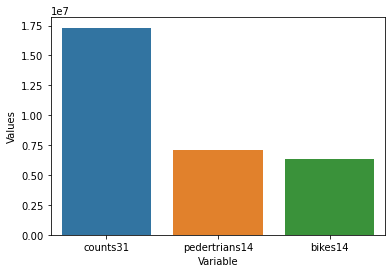

In [21]:
import seaborn as sns
from dfply import *

viz = (weekly_data_sum_counts >> gather('Variable', 'Values', ['counts31','pedertrians14','bikes14']))
sns.barplot(data=viz, x="Variable", y="Values")